In [45]:
from distance.EuclideanDistance import EuclideanDistance
from utilities.visualization import Visualizer
from utilities.dataset_factory import DatasetFactory
import numpy as np
import os
import random
import keras
from CL_utilities import loss_function

# Hyperparameters

In [46]:
image_size = (258, 320)
epochs = 10
batch_size = 16
margin = 0.5
training_pairs = 280
validation_pairs = 40
data_path = r"/Users/filip/projekt_zespolowy/fruits-360"
training_path = os.path.join(data_path, "Training")
validation_path = os.path.join(data_path, "Test")

# Building training dataset 
# (1.) See Documentation to get info about structure of dataset

In [47]:
training_dataset = DatasetFactory.build_dataset(ds_path=training_path,
                                                image_size=image_size,
                                                batch_size=batch_size,
                                                max_iterations=training_pairs,
                                                method="contrastive_loss")
print(training_dataset)

<_BatchDataset element_spec=((TensorSpec(shape=(None, 258, 320, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 258, 320, 3), dtype=tf.float32, name=None)), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>


(258, 320, 3)


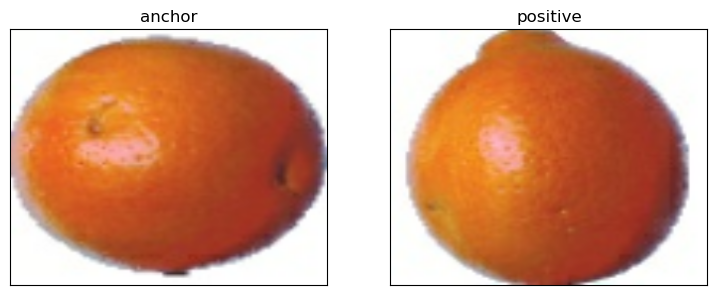

In [48]:
image, _ = next(iter(training_dataset))
anchor_img = np.asarray(image[0][0]).astype('float32')
positive_img = np.asarray(image[1][0]).astype('float32')

Visualizer.visualize(**{"anchor": anchor_img, "positive" : positive_img})
print(anchor_img.shape)

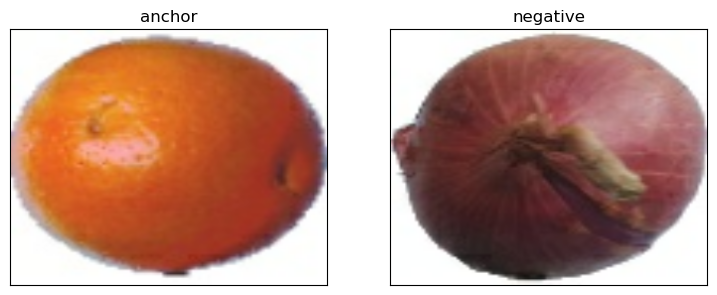

In [49]:
anchor_img = np.asarray(image[0][1]).astype('float32')
negative_img = np.asarray(image[1][1]).astype('float32')
Visualizer.visualize(**{"anchor": anchor_img, "negative" : negative_img})

# Creating validation dataset

In [50]:
validation_dataset = DatasetFactory.build_dataset(ds_path=validation_path,
                                                image_size=image_size,
                                                batch_size=batch_size,
                                                max_iterations=training_pairs,
                                                method="contrastive_loss")
print(validation_dataset)

<_BatchDataset element_spec=((TensorSpec(shape=(None, 258, 320, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 258, 320, 3), dtype=tf.float32, name=None)), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>


(258, 320, 3)


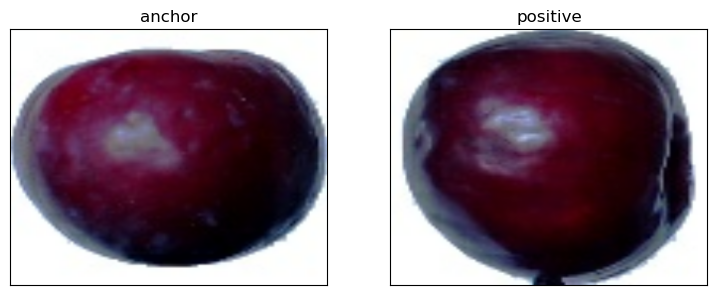

In [51]:
image, _ = next(iter(validation_dataset))
anchor_img = np.asarray(image[0][0]).astype('float32')
positive_img = np.asarray(image[1][0]).astype('float32')

Visualizer.visualize(**{"anchor": anchor_img, "positive" : positive_img})
print(anchor_img.shape)

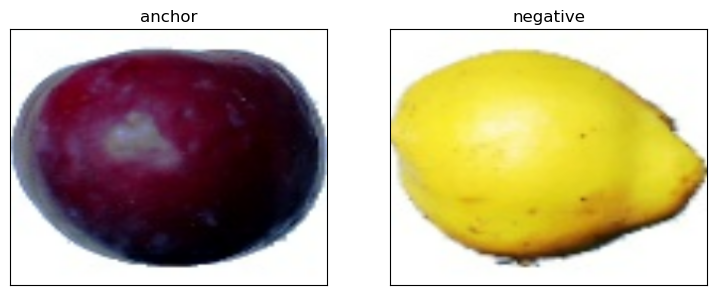

In [52]:
anchor_img = np.asarray(image[0][1]).astype('float32')
negative_img = np.asarray(image[1][1]).astype('float32')
Visualizer.visualize(**{"anchor": anchor_img, "negative" : negative_img})

In [53]:
input_layer = keras.layers.Input((258,320,3))
x = keras.layers.BatchNormalization()(input_layer)
x = keras.layers.Conv2D(32, (5,5), activation="relu")(x)  # ilość elementów filtra, rozmiar filtra
x = keras.layers.AveragePooling2D(pool_size=(2,2))(x)
x = keras.layers.Conv2D(64, (3,3), activation="relu")(x)
x = keras.layers.AveragePooling2D(pool_size=(2,2))(x)
x = keras.layers.Flatten()(x)

x = keras.layers.Dense(64, activation="relu")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(16, activation="relu")(x)
embedding_network = keras.Model(input_layer, x)   # tworzę instancję modelu. Model nazywam embedding network
                                            # używam tego do dalszego definiowania modelu


In [54]:
input_1 = keras.layers.Input(image_size + (3,))
input_2 = keras.layers.Input(image_size + (3,))

tower_1 = embedding_network(input_1)
tower_2 = embedding_network(input_2)

# euclidean_distance = 
merge_layer = keras.layers.Lambda(EuclideanDistance(), output_shape=(1,))([tower_1, tower_2])

normal_layer = keras.layers.BatchNormalization()(merge_layer)
output_layer = keras.layers.Dense(1, activation="sigmoid")(normal_layer)

siamese = keras.Model(inputs=[input_1, input_2], outputs=output_layer)

In [55]:
siamese.compile(loss=loss_function.loss(margin=margin), optimizer='adam', metrics=['accuracy'])
siamese.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 258, 320,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_8       │ (None, 258, 320,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_9        │ (None, 16)        │ 19,830,556 │ input_layer_7[0]… │
│ (Functional)        │                   │            │ input_layer_8[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_2 (Lambda)   │ (None, 1)         │          0 │ functional_9[0][… │
│                     │                   │            │ functional_9[1][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1)         │          4 │ lambda_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 1)         │          2 │ batch_normalizat… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 19,830,562 (75.65 MB)

 Trainable params: 19,830,426 (75.65 MB)

 Non-trainable params: 136 (544.00 B)

In [103]:
# How many samples we have, and how many we want in train and validation
# num_samples = sum(1 for _ in touple_of_products)
# train_size = int(0.8 * num_samples)
# val_size = num_samples - train_size
# # .take() to get from actual batch
# train_dataset = touple_of_products.take(train_size)
# val_dataset = touple_of_products.skip(train_size)

Trained_model_data = siamese.fit(training_dataset, 
                                 validation_data= validation_dataset, 
                                 batch_size = batch_size,
                                 epochs = epochs
                                )

Epoch 1/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.4909 - loss: 0.0920 - val_accuracy: 0.5000 - val_loss: 0.0963
Epoch 2/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.5007 - loss: 0.0876 - val_accuracy: 0.5000 - val_loss: 0.0855
Epoch 3/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 63s 2s/step - accuracy: 0.5000 - loss: 0.0873 - val_accuracy: 0.5000 - val_loss: 0.0869
Epoch 4/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - accuracy: 0.5000 - loss: 0.0791 - val_accuracy: 0.5000 - val_loss: 0.0886
Epoch 5/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.5000 - loss: 0.0767 - val_accuracy: 0.5000 - val_loss: 0.0828
Epoch 6/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.5000 - loss: 0.0804 - val_accuracy: 0.5000 - val_loss: 0.0802
Epoch 7/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 91s 3s/step - accuracy: 0.5000 - loss: 0.0745 - val_accuracy: 0.5000 - val_loss: 0.0783
Epoch 8/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 73s 2s/step - accuracy: 0.5000 - loss: 0.0769 - val_accuracy: 0.5000 - val_loss:

# Visualize wrong predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 537ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 620ms/step


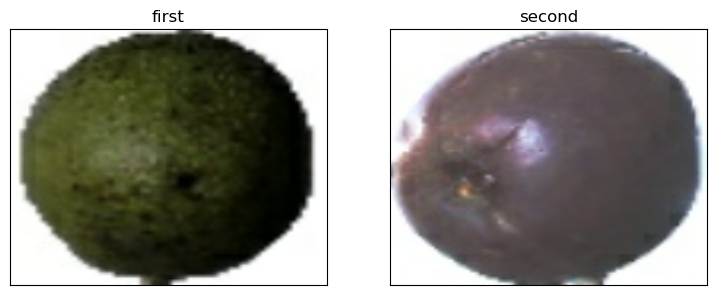

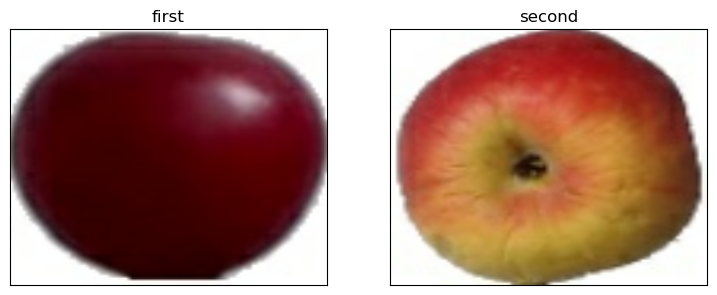

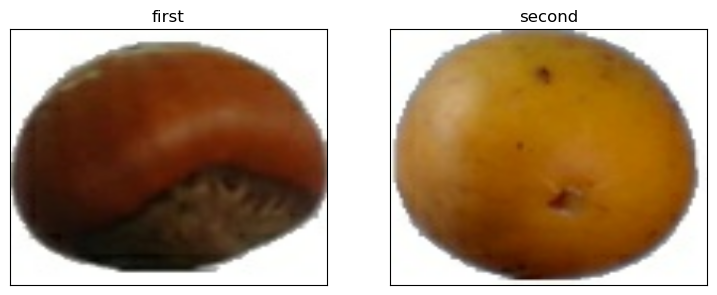

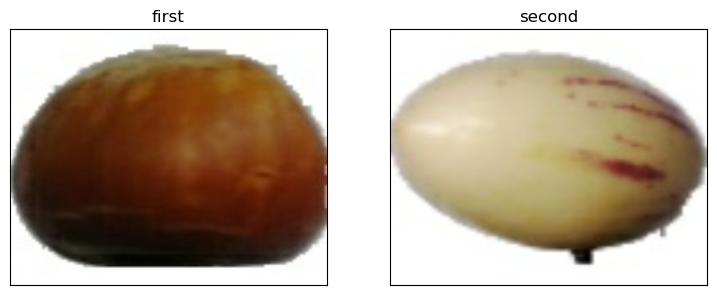

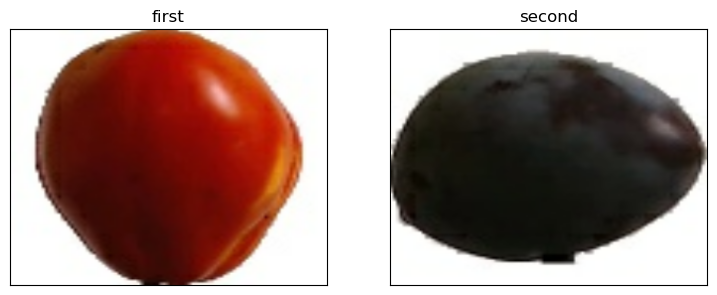

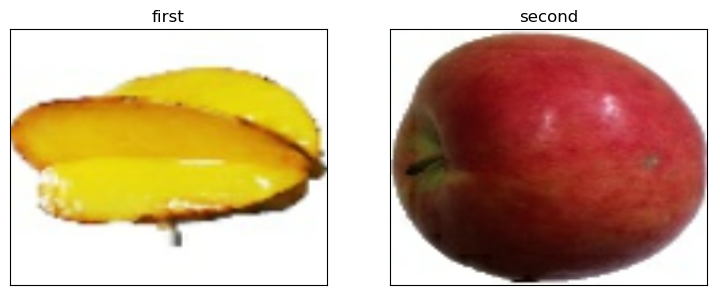

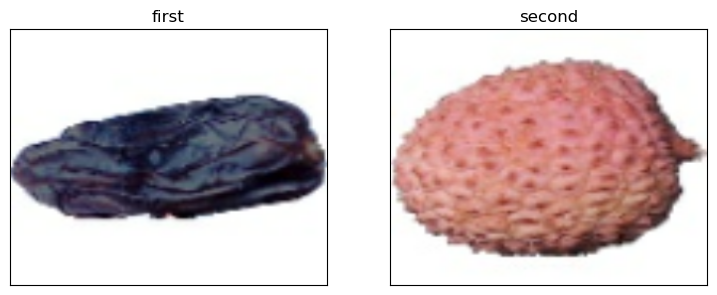

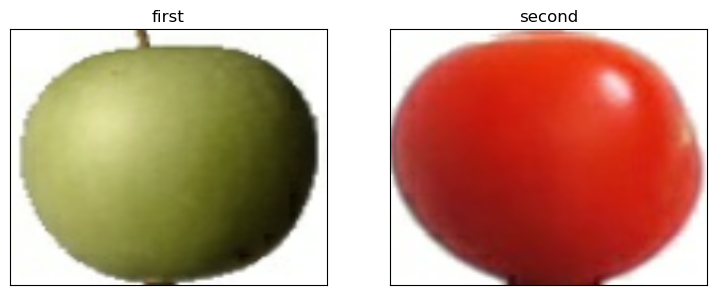

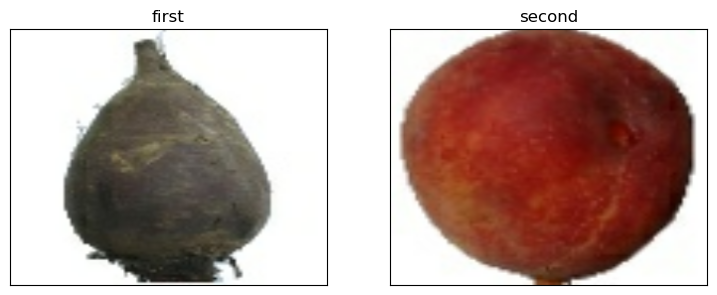

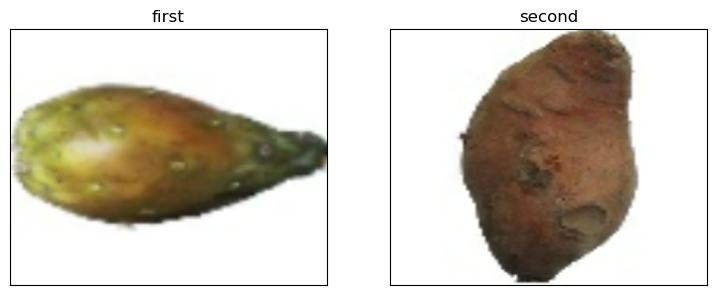

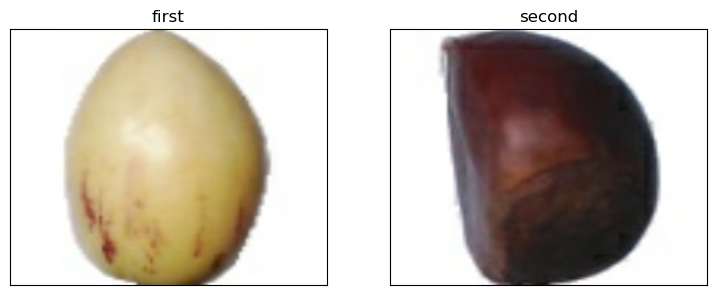

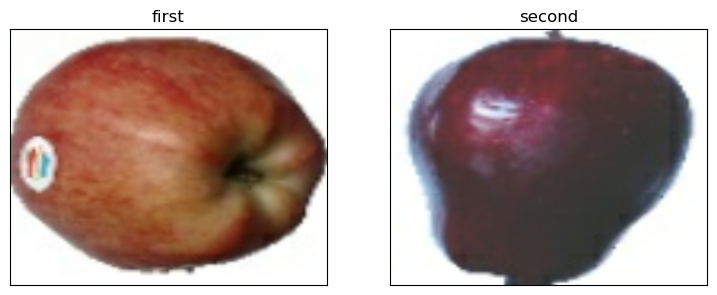

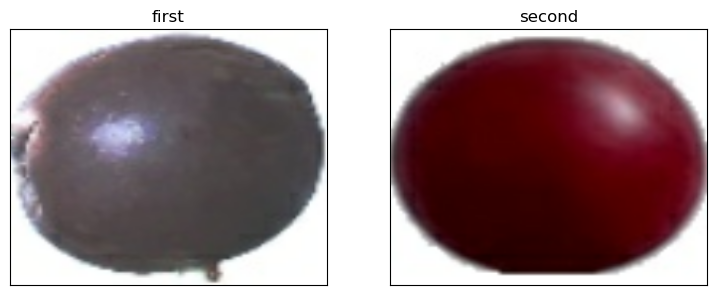

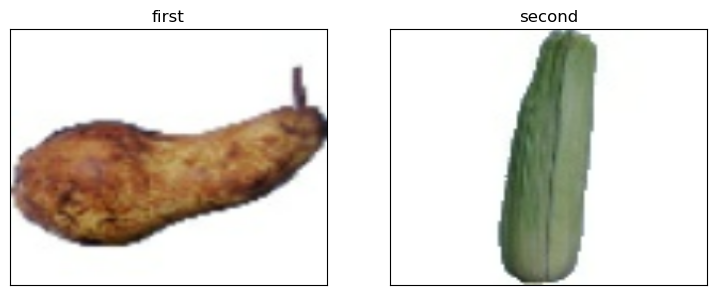

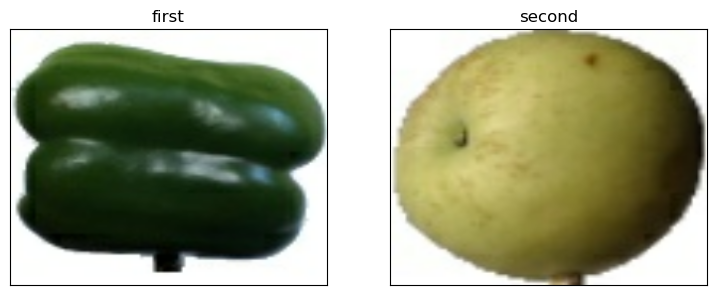

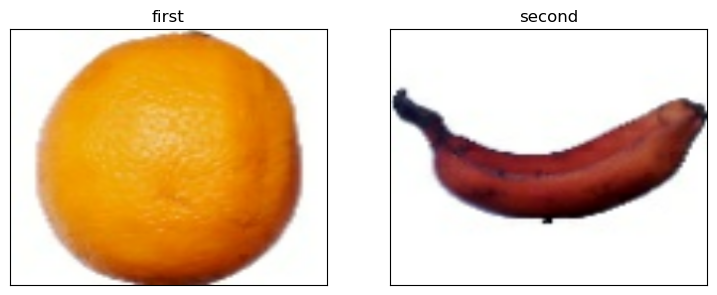

In [130]:
# creating test dataset
test_dataset = DatasetFactory.build_dataset(ds_path=validation_path,
                                            image_size=image_size,
                                            batch_size=batch_size,
                                            max_iterations=16,
                                            method="contrastive_loss")

for image, label in test_dataset:
    # making prediction based on one batch of data
    prediction = siamese.predict(image)
    for i in range(len(prediction)):
        # checking if each prediction is the same as the label
        if not round(prediction[i][0]) == label[i]:
            # if prediction is different from label then display images
            first_img = np.asarray(image[0][i]).astype('float32')
            second_img = np.asarray(image[1][i]).astype('float32')

            Visualizer.visualize(**{"first": first_img, "second" : second_img})